In [3]:
import scipy

round(scipy.stats.distributions.poisson.pmf(16, 16), 3)

0.099

In [7]:
import numpy as np
round(np.exp(-1/10*7), 3)

0.497

In [16]:
round(np.exp((-1/10)*9)*(1-np.exp((-1/10)*11)), 3)

0.271

In [19]:
(1-np.exp(-1/10*11)) - (1-np.exp((-1/10)*9))

0.07369857604251961

In [21]:
0.3*0.2


0.06

In [30]:
import pandas as pd
ames_data = pd.read_csv('data/AmesHousing.csv')
ames_data = ames_data[(ames_data["Lot Frontage"] <= 150) & (ames_data["Lot Area"] <= 20000)]

ames_sample = ames_data[["Lot Frontage", "Lot Area", "SalePrice"]].sample(
    n=15, random_state=42, ignore_index=True
)

X = ames_sample[["Lot Frontage", "Lot Area"]]
y = ames_sample["SalePrice"]

In [36]:
def squared_error(y):
    y_pred = y.mean()
    return ((y - y_pred) ** 2).mean()

def split(X, y, split_params):
    j, t = split_params
    predicat = X.iloc[:, j] <= t
    X_left, y_left = X[predicat], y[predicat]
    X_right, y_right = X[~predicat], y[~predicat]
    return X_left, y_left, X_right, y_right

def calculate_weighted_impurity(X, y, split_params, criterion):
    X_left, y_left, X_right, y_right = split(X, y, split_params)
    N, N_left, N_right  = y.size, y_left.size, y_right.size
    score = N_left / N * criterion(y_left) + N_right / N * criterion(y_right)
    return score

def find_candidates_for_thresholds(x, y):
    x = x.sort_values().drop_duplicates()
    x_roll_mean = x.rolling(2).mean().dropna()
    y = y[x_roll_mean.index]
    y_roll_mean = y.diff()
    candidates = x_roll_mean[y_roll_mean != 0]
    return candidates.values

def best_split(X, y, criterion):
    M = X.shape[1]
    min_weighted_impurity = np.inf
    optimal_split_params = None
    for j in range(M):
        thresholds = find_candidates_for_thresholds(X.iloc[:, j], y)
        for t in thresholds:
            split_params = (j, t)
            weighted_impurity = calculate_weighted_impurity(X, y, split_params, criterion)
            if weighted_impurity < min_weighted_impurity:
                min_weighted_impurity = weighted_impurity
                optimal_split_params = split_params
    return optimal_split_params

def entropy(y):
    p = y.value_counts(normalize=True)
    entropy = -np.sum(p * np.log2(p))
    return entropy

In [32]:
optimal_split_params = best_split(X, y, criterion=squared_error)
print('Optimal j: {}'.format(optimal_split_params[0]))
print('Optimal t: {}'.format(optimal_split_params[1]))

Optimal j: 0
Optimal t: 71.0


In [33]:
calculate_weighted_impurity(X, y, optimal_split_params, criterion=squared_error)

1414654917.0222223

In [34]:
bill_data = pd.read_csv('data/bill_authentication.csv')
bill_sample = bill_data[['Variance', 'Skewness', 'Class']].sample(
    n=15, 
    random_state=42, 
    ignore_index=True
)
# Создаём обучающую выборку
X = bill_sample[['Variance', 'Skewness']]
y = bill_sample['Class']

In [37]:
optimal_split_params = best_split(X, y, criterion=entropy)
print('Optimal j: {}'.format(optimal_split_params[0]))
print('Optimal t: {}'.format(optimal_split_params[1]))

Optimal j: 1
Optimal t: 3.22085


In [38]:
calculate_weighted_impurity(X, y, optimal_split_params, criterion=entropy)

0.45977313014931737

In [39]:
class Node:
    def __init__(self, left=None, 
                 right=None, value=None, 
                 split_params=None, impurity=None,
                 samples=None, is_leaf=False):
        self.left = left
        self.right = right
        self.split_params = split_params
        self.value = value
        self.impurity = impurity
        self.samples = samples
        self.is_leaf = is_leaf

def create_leaf_prediction(y):
    value = y.mode()[0]
    return value

def stopping_criterion(X, y, criterion):
    return criterion(y) == 0

def build_decision_tree(X, y, criterion):
    if stopping_criterion(X, y, criterion):
        value = create_leaf_prediction(y)
        node = Node(
            value=value, 
            impurity=criterion(y), 
            samples=y.size,
            is_leaf=True
        )
    else:
        split_params = best_split(X, y, criterion=entropy)
        X_left, y_left, X_rigth, y_right = split(X, y, split_params)
        left = build_decision_tree(X_left, y_left, criterion)
        right = build_decision_tree(X_rigth, y_right, criterion)       
        node = Node(
            left=left, right=right, 
            split_params=split_params, 
            impurity=criterion(y), 
            samples=y.size
        )
    return node

def print_decision_tree(node, depth=0):
    depth += 1
    if node.is_leaf:
        print('   ' * depth, 'class: {}'.format(node.value))
    else:
        print('   ' * depth, 'feature_{} <= {:.3f}:'.format(*node.split_params))
        print_decision_tree(node.left, depth=depth)
        print('   ' * depth, 'feature_{} > {:.3f}:'.format(*node.split_params))
        print_decision_tree(node.right, depth=depth)
        
# Создаем обучающую выборку
bill_data = pd.read_csv('data/bill_authentication.csv')
bill_sample = bill_data[['Variance', 'Skewness', 'Class']].sample(
    n=15, 
    random_state=42, 
    ignore_index=True
)
# Создаём обучающую выборку
X = bill_sample[['Variance', 'Skewness']]
y = bill_sample['Class']
# Строим дерево решений и печатаем его на экран
decision_tree = build_decision_tree(X, y, criterion=entropy)
print_decision_tree(decision_tree)

    feature_1 <= 3.221:
       feature_0 <= 2.756:
          feature_0 <= -1.254:
             class: 0
          feature_0 > -1.254:
             feature_0 <= -0.063:
                class: 1
             feature_0 > -0.063:
                feature_0 <= 0.988:
                   class: 0
                feature_0 > 0.988:
                   class: 1
       feature_0 > 2.756:
          class: 0
    feature_1 > 3.221:
       class: 0


In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import tree
from sklearn import model_selection
from sklearn import metrics

In [42]:
voice_data = pd.read_csv('data/voice_gender.csv')
voice_data.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402905,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [44]:
voice_data.isnull().sum()

meanfreq    0
sd          0
median      0
Q25         0
Q75         0
IQR         0
skew        0
kurt        0
sp.ent      0
sfm         0
mode        0
centroid    0
meanfun     0
minfun      0
maxfun      0
meandom     0
mindom      0
maxdom      0
dfrange     0
modindx     0
label       0
dtype: int64

In [50]:
X = voice_data.drop('label', axis=1)
y = voice_data['label']

In [51]:
# Формируем обучающую и тестовую выборки
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (2534, 20)
Test shape: (634, 20)


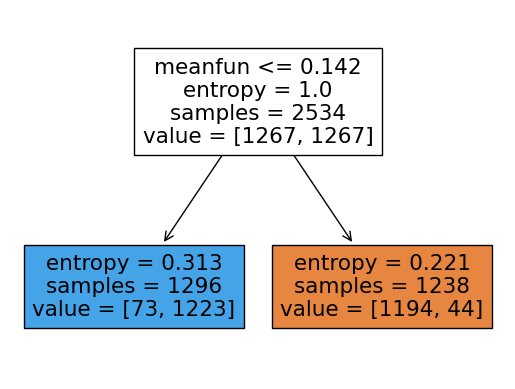

In [55]:
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=1
)

dt.fit(X_train, y_train)
tree.plot_tree(
    decision_tree=dt,
    feature_names=X_train.columns,
    filled=True,
    impurity=True,
);

In [59]:
y_test_predict = dt.predict(X_test)
print(round(metrics.accuracy_score(y_test, y_test_predict), 3))

0.962


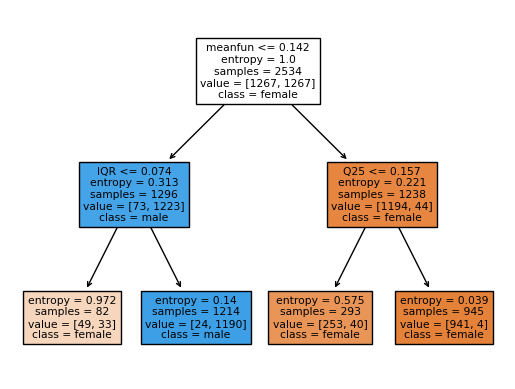

In [58]:
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=2
)

dt.fit(X_train, y_train)
tree.plot_tree(
    decision_tree=dt,
    feature_names=X_train.columns,
    filled=True,
    impurity=True,
    class_names=dt.classes_
);

In [60]:
y_test_predict = dt.predict(X_test)
print(round(metrics.accuracy_score(y_test, y_test_predict), 3))

0.962


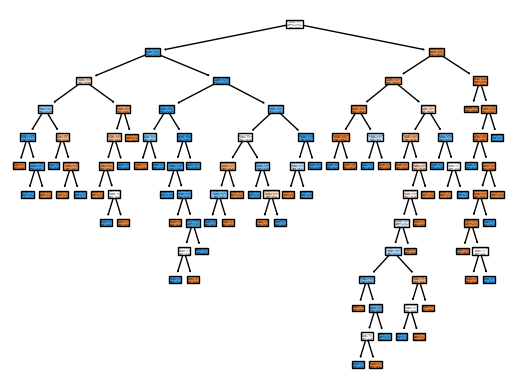

In [61]:
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=0
)

dt.fit(X_train, y_train)
tree.plot_tree(
    decision_tree=dt,
    feature_names=X_train.columns,
    filled=True,
    impurity=True,
    class_names=dt.classes_
);

In [62]:
dt.get_depth()

12

In [63]:
dt.get_n_leaves()

54

In [64]:
y_train_predict = dt.predict(X_train)
y_test_predict = dt.predict(X_test)
print('Train accuracy:')
print(round(metrics.accuracy_score(y_train, y_train_predict), 3))
print('Test accuracy:')
print(round(metrics.accuracy_score(y_test, y_test_predict), 3))

Train accuracy:
1.0
Test accuracy:
0.973


In [65]:
# Задаём сетку параметров
param_grid = {
    'criterion': ['gini', 'entropy'], #критерий информативности
    'max_depth': [4, 5, 6, 7, 8, 9, 10], #максимальная глубина дерева
    'min_samples_split': [3, 4, 5, 10] #минимальное количество объектов, необходимое для сплита
}

# Задаём метод кросс-валидации
cv = model_selection.StratifiedKFold(n_splits=5)

grid_search = model_selection.GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring='accuracy',
    cv=cv
)

grid_search.fit(X_train, y_train)
grid_search.best_params_

{'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 3}

In [66]:
y_train_predict = grid_search.predict(X_train)
y_test_predict = grid_search.predict(X_test)
print('Train accuracy:')
print(round(metrics.accuracy_score(y_train, y_train_predict), 3))
print('Test accuracy:')
print(round(metrics.accuracy_score(y_test, y_test_predict), 3))

Train accuracy:
0.996
Test accuracy:
0.97


In [69]:
dt_best = tree.DecisionTreeClassifier(
    criterion='gini',
    max_depth=7,
    min_samples_split=3,
    random_state=0
)
dt_best.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, min_samples_split=3, random_state=0)

In [70]:
dt_best.feature_importances_

array([0.00257071, 0.00412021, 0.00324731, 0.00143184, 0.00361359,
       0.05681024, 0.00419621, 0.00654448, 0.00091911, 0.01800429,
       0.0060468 , 0.00598505, 0.86134736, 0.01415259, 0.        ,
       0.00119966, 0.00153412, 0.        , 0.00688824, 0.0013882 ])

<AxesSubplot: >

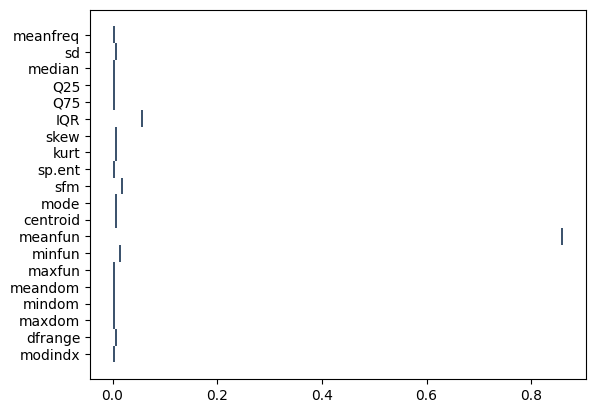

In [71]:
sns.histplot(
    x=dt_best.feature_importances_,
    y=X.columns
)